<a href="https://colab.research.google.com/github/rudra404/NLP-RNN-Emotions-Classification/blob/main/GoEmotions_RNN_experiment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoEmotions Experiment 4: Testing different language models for fine-tuning


In this notebook,

### Set up steps for notebook
---
Required packages and dependencies are installed with compatible versions and the notebook is set up to use GPU when available.

---

In [ ]:
# Install required packages
!pip install datasets
!pip install evaluate
!pip install transformers

# Install dependencies
%pip install torch==1.11.0+cu113 torchdata==0.3.0 torchtext==0.12.0 -f https://download.pytorch.org/whl/cu113/torch_stable.html
%pip install spacy tqdm
!python -m spacy download en_core_web_sm

# Initialise torch and use GPU
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.2 MB/s eta 0:0

Use this cell to mount your Google Drive on the notebook. Some files in the zip folder are used to reduce repeating of some setup steps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---



---



---





---


### Data Preprocessing

Getting our data ready to be used by pre-trained models and their tokenizers


---



In [ ]:
from datasets import load_dataset
import pandas as pd

# load the GoEmotions dataset
goemotions_dataset = load_dataset('go_emotions')

# get the train, validation, and test splits as Pandas dataframes
train_df = goemotions_dataset['train'].to_pandas()
val_df = goemotions_dataset['validation'].to_pandas()
test_df = goemotions_dataset['test'].to_pandas()

# concatenate the splits into a single dataframe
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# duplicate the records with multiple labels
df = df.explode('labels')

# reset the index of the dataframe
df = df.reset_index(drop=True)

# print the first five rows of the resulting dataframe
print(df.head())


  0%|          | 0/3 [00:00<?, ?it/s]

                                                text labels       id
0  My favourite food is anything I didn't have to...     27  eebbqej
1  Now if he does off himself, everyone will thin...     27  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING      2  eezlygj
3                        To make her feel threatened     14  ed7ypvh
4                             Dirty Southern Wankers      3  ed0bdzj


In [ ]:
### MERGING EMOTION LABELS FROM GROUP DECISIONS ###

for i, row in df.iterrows():
  # Converting Annoyance [3] into Anger [2]
  if row['labels']==3:
    row['labels']=2
  # Disappointment [9] and Grief [16] into Sadness [25]
  if row['labels']==9 or row['labels']==16:
    row['labels']=25
  # Converting Nervousness [19] into Fear [14]
  if row['labels']==19:
    row['labels']=14
  # Converting Excitement [13] into Joy [17]
  if row['labels']==13:
    row['labels']=17

#keeps just one of the records where there are labelled with both merged classes
df = df.drop_duplicates(keep = 'first')
drop_labels = (3,11,12,9,16,19,22,26,21,13,0,23,20,5)
#drops labels we are not using
df_cut = df[~df.labels.isin(drop_labels)]
#deletes duplicates
df_cut = df_cut.drop_duplicates(subset = ['text'], keep = False)
df_cut = df_cut.reset_index(drop = True)

### REORDERING SO THAT LABELS ARE 0-13 ###
for i, row in df_cut.iterrows():
    # Converting Neutral [27] to Neutral [0]
    if row['labels']==27:
        row['labels']=0
    # Converting Sadness [25] to Sadness [3]
    if row['labels']==25:
        row['labels']=3
    # Converting Remorse [24] to Remorse [5]
    if row['labels']==24:
        row['labels']=5
    # Converting Love [18] to Love [9]
    if row['labels']==18:
        row['labels']=9
    # Converting Fear [14] to Fear [11]
    if row['labels']==14:
        row['labels']=11
    # Converting Gratitude [15] to Gratitude [12]
    if row['labels']==15:
        row['labels']=12
    # Converting Joy [17] to Joy [13]
    if row['labels']==17:
        row['labels']=13

df = df_cut
# reset the index of the dataframe
df = df.reset_index(drop=True)
#rearrange columns
columns_titles = ["labels","text"]
df=df.reindex(columns=columns_titles)

df.head()

,labels,text
0,0,My favourite food is anything I didn't have to...
1,0,"Now if he does off himself, everyone will thin..."
2,2,WHY THE FUCK IS BAYLESS ISOING
3,11,To make her feel threatened
4,2,Dirty Southern Wankers


In [ ]:
# converting dataframe to dataset type
from datasets import Dataset
dataset = Dataset.from_pandas(df)

### Other common steps

In [ ]:
# !pip install --upgrade accelerate
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.29.1
Uninstalling transformers-4.29.1:
  Successfully uninstalled transformers-4.29.1
Found existing installation: accelerate 0.19.0
Uninstalling accelerate-0.19.0:
  Successfully uninstalled accelerate-0.19.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.29.1-py3-none-any.whl (7.1 MB)
  Using cached accelerate-0.19.0-py3-none-any.whl (219 kB)


In [ ]:
# define a function to get validation accuracy while training
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# set training arguments
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=20.0)

The below cells are only used for saving and loading the models in case of a crash or runtime disconnection.

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained('/content/drive/MyDrive/Colab Notebooks/NLP CW')

NameError: ignored

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/bert-base')



---



---



---

## 4.A. bert-based-cased

In [ ]:
# tokenize the data
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_dataset = dataset.map(tokenize_function, batched=True)

# split the data - using only 2000 instances for training due to the time and resources taken
from torch.utils.data import random_split

# split dataset into train and test sets
train_samples = 4000
test_samples = len(tokenized_dataset) - train_samples
train_data, test_data = random_split(tokenized_dataset, [train_samples, test_samples])

# split train subset into train and validation sets
train_samples = 2000
valid_samples = 2000
train_data, valid_data = random_split(train_data, [train_samples, valid_samples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


Map:   0%|          | 0/41131 [00:00<?, ? examples/s]

Number of training examples: 2000
Number of validation examples: 2000
Number of testing examples: 37131


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=14)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=valid_data,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.376327,0.591500
2,1.536500,1.307670,0.601500
3,1.536500,1.479889,0.594500
4,0.505200,1.766064,0.633500
5,0.505200,2.133593,0.608500
6,0.127100,2.329968,0.616000
7,0.127100,2.570839,0.625000
8,0.029900,2.644820,0.622500
9,0.029900,2.771687,0.614000
10,0.002600,2.781242,0.625000


TrainOutput(global_step=5000, training_loss=0.2203055982068181, metrics={'train_runtime': 5245.7013, 'train_samples_per_second': 7.625, 'train_steps_per_second': 0.953, 'total_flos': 1.052557615104e+16, 'train_loss': 0.2203055982068181, 'epoch': 20.0})

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained('/content/drive/MyDrive/Colab Notebooks/bert-base')

In [ ]:
small_test_data = torch.utils.data.Subset(test_data, range(5000))

Test Acc: 61.80% | Test F1: 0.619

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.69      1982
           1       0.80      0.71      0.75       286
           2       0.49      0.51      0.50       416
           3       0.50      0.45      0.47       282
           4       0.36      0.42      0.39       335
           5       0.57      0.77      0.66        61
           6       0.35      0.24      0.29       137
           7       0.44      0.67      0.53       212
           8       0.59      0.49      0.54        75
           9       0.75      0.84      0.79       255
          10       0.38      0.40      0.39       267
          11       0.64      0.52      0.58        90
          12       0.90      0.89      0.90       346
          13       0.62      0.53      0.57       256

    accuracy                           0.62      5000
   macro avg       0.58      0.58      0.57      5000
weighted avg       0.6

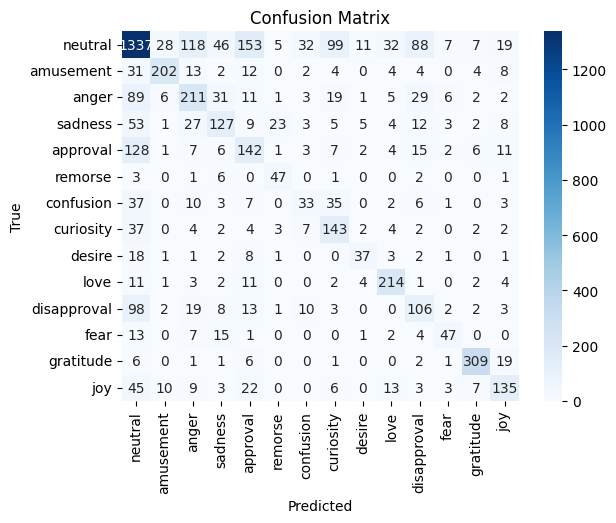

In [ ]:
## EVALUATE ON TEST DATA
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

# get predictions from test dataset
predictions = trainer.predict(test_dataset=small_test_data)

# get predicted labels and true labels
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids


# calculate required metrics and reports
test_acc = accuracy_score(true_labels, pred_labels)
test_f1 = f1_score(true_labels, pred_labels, average='weighted')
test_cm = confusion_matrix(true_labels, pred_labels)
test_report = classification_report(true_labels, pred_labels)

# print metrics
print(f'Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f}')
print(f'\nClassification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---

## 4.B. EmoRoBERTa

In [ ]:
# tokenize the data
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("arpanghoshal/EmoRoBERTa")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_dataset = dataset.map(tokenize_function, batched=True)

# split the data - using only 2000 instances for training due to the time and resources taken
from torch.utils.data import random_split

# split dataset into train and test sets
train_samples = 4000
test_samples = len(tokenized_dataset) - train_samples
train_data, test_data = random_split(tokenized_dataset, [train_samples, test_samples])

# split train subset into train and validation sets
train_samples = 2000
valid_samples = 2000
train_data, valid_data = random_split(train_data, [train_samples, valid_samples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


Map:   0%|          | 0/41131 [00:00<?, ? examples/s]

Number of training examples: 2000
Number of validation examples: 2000
Number of testing examples: 37131


In [ ]:
from transformers import AutoModelForSequenceClassification

# define the model
model = AutoModelForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa", from_tf=True)

# training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=valid_data,
    compute_metrics=compute_metrics,
)

trainer.train()

All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.599391,0.834000
2,0.730100,0.693596,0.848000
3,0.730100,0.906186,0.843000
4,0.105000,0.935094,0.850500
5,0.105000,0.940960,0.852500


TrainOutput(global_step=1250, training_loss=0.3393719425201416, metrics={'train_runtime': 1232.9584, 'train_samples_per_second': 8.111, 'train_steps_per_second': 1.014, 'total_flos': 2631724769280000.0, 'train_loss': 0.3393719425201416, 'epoch': 5.0})

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Acc: 83.22% | Test F1: 0.834

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2030
           1       0.86      0.95      0.90       258
           2       0.83      0.81      0.82       459
           3       0.70      0.78      0.74       258
           4       0.72      0.75      0.74       353
           5       0.70      0.81      0.75        67
           6       0.65      0.68      0.66       107
           7       0.74      0.79      0.77       248
           8       0.70      0.83      0.75        69
           9       0.81      0.91      0.86       243
          10       0.79      0.77      0.78       243
          11       0.76      0.85      0.80        80
          12       0.94      0.93      0.94       341
          13       0.78      0.79      0.79       244
          22       0.00      0.00      0.00         0
          26       0.00      0.00      0.00         0

    accuracy          

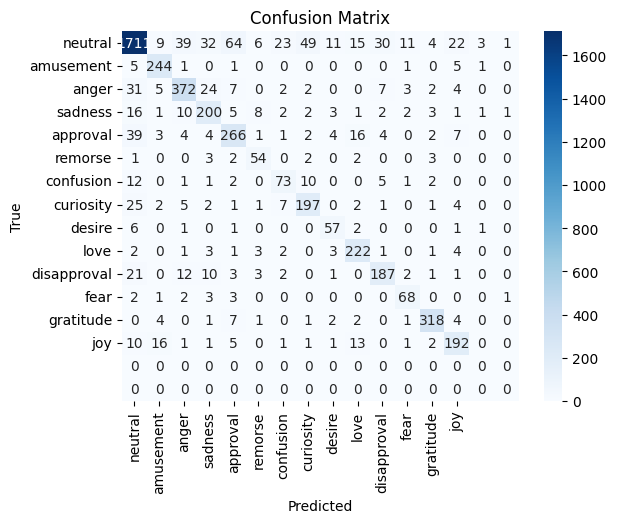

In [ ]:
## EVALUATE ON TEST DATA
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

# get predictions from test dataset
predictions = trainer.predict(test_dataset=small_test_data)

# get predicted labels and true labels
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# calculate required metrics and reports
test_acc = accuracy_score(true_labels, pred_labels)
test_f1 = f1_score(true_labels, pred_labels, average='weighted')
test_cm = confusion_matrix(true_labels, pred_labels)
test_report = classification_report(true_labels, pred_labels)

# print metrics
print(f'Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f}')
print(f'\nClassification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---

## 4.C. all-MiniLM-L6-v2

In [ ]:
# tokenize the data
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_dataset = dataset.map(tokenize_function, batched=True)

# split the data - using only 2000 instances for training due to the time and resources taken
from torch.utils.data import random_split

# split dataset into train and test sets
train_samples = 4000
test_samples = len(tokenized_dataset) - train_samples
train_data, test_data = random_split(tokenized_dataset, [train_samples, test_samples])

# split train subset into train and validation sets
train_samples = 2000
valid_samples = 2000
train_data, valid_data = random_split(train_data, [train_samples, valid_samples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


Map:   0%|          | 0/41131 [00:00<?, ? examples/s]

Number of training examples: 2000
Number of validation examples: 2000
Number of testing examples: 37131


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("sentence-transformers/all-MiniLM-L6-v2", num_labels=14)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=valid_data,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.830709,0.451000
2,1.891200,1.620486,0.534000
3,1.891200,1.548659,0.549000
4,1.320300,1.575816,0.529000
5,1.320300,1.563553,0.547000


TrainOutput(global_step=1250, training_loss=1.50099365234375, metrics={'train_runtime': 308.4784, 'train_samples_per_second': 32.417, 'train_steps_per_second': 4.052, 'total_flos': 331800023040000.0, 'train_loss': 1.50099365234375, 'epoch': 5.0})

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained('/content/drive/MyDrive/Colab Notebooks/all-MiniLM-L6-v2')

In [ ]:
small_test_data = torch.utils.data.Subset(test_data, range(5000))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Acc: 53.02% | Test F1: 0.487

Classification report:
              precision    recall  f1-score   support

           0       0.64      0.74      0.68      2007
           1       0.68      0.86      0.76       281
           2       0.27      0.63      0.37       445
           3       0.25      0.13      0.17       292
           4       0.30      0.08      0.12       369
           5       0.50      0.37      0.43        67
           6       0.00      0.00      0.00       134
           7       0.32      0.09      0.14       233
           8       0.55      0.30      0.39        77
           9       0.52      0.74      0.61       222
          10       0.15      0.02      0.04       238
          11       0.00      0.00      0.00        87
          12       0.89      0.88      0.88       325
          13       0.30      0.28      0.29       223

    accuracy                           0.53      5000
   macro avg       0.38      0.37      0.35      5000
weighted avg       0.4

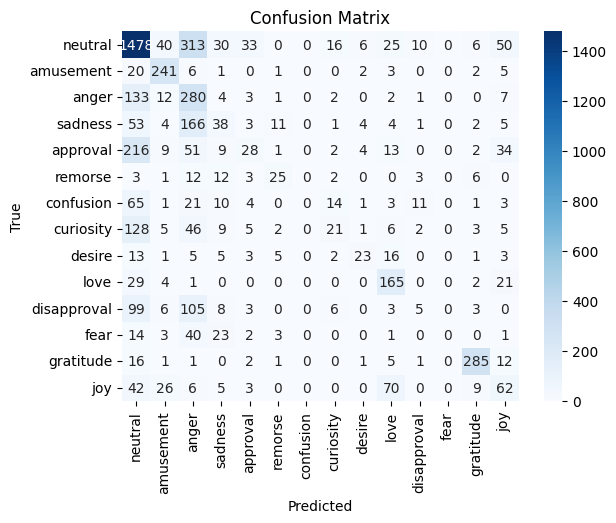

In [ ]:
## EVALUATE ON TEST DATA
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

# get predictions from test dataset
predictions = trainer.predict(test_dataset=small_test_data)

# get predicted labels and true labels
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids


# calculate required metrics and reports
test_acc = accuracy_score(true_labels, pred_labels)
test_f1 = f1_score(true_labels, pred_labels, average='weighted')
test_cm = confusion_matrix(true_labels, pred_labels)
test_report = classification_report(true_labels, pred_labels)

# print metrics
print(f'Test Acc: {test_acc*100:.2f}% | Test F1: {test_f1:.3f}')
print(f'\nClassification report:\n{test_report}')

# plot confusion matrix
# labels for the plot - same as labels used for label_vocab
labels = OrderedDict([("neutral", 1), ("amusement", 1), ("anger", 1), ("sadness", 1), ("approval", 1), ("remorse", 1), ("confusion", 1), ("curiosity", 1), ("desire", 1), ("love", 1), ("disapproval", 1), ("fear", 1), ("gratitude", 1), ("joy", 1)])
# create the heatmap
sns.heatmap(test_cm, cmap="Blues", annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
# add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



---



---



---

## Results

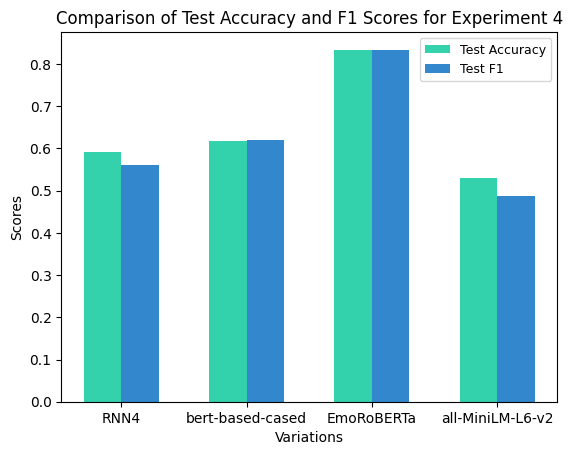

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

variations = ['RNN4', 'bert-based-cased', 'EmoRoBERTa', 'all-MiniLM-L6-v2']
test_accuracy_list = [0.5907, 0.6180, 0.8322, 0.5302]
test_f1_list = [0.56, 0.619, 0.834, 0.487]

fig, ax = plt.subplots()

# Create x-axis values so it can be used for any number of variations
x_values = np.arange(len(variations))

# Plot the bar charts
rects1 = ax.bar(x_values, test_accuracy_list, 0.3, alpha=0.8, color='#00c698', label='Test Accuracy')
rects2 = ax.bar(x_values + 0.3, test_f1_list, 0.3, alpha=0.8, color='#0069c0', label='Test F1')

# Add labels and titles
ax.set_xlabel('Variations')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Test Accuracy and F1 Scores for Experiment 4')
ax.set_xticks(x_values + 0.3 / 2)
ax.set_xticklabels(variations)
ax.legend(fontsize=9)

# Show the plot
plt.show()




---





---



---

## Conclusion



---
---
---

